# License 
***
Copyright 2017 J. Patrick Hall, jphall@gwu.edu & Navdeep Gill, navdeep@h2o.ai

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Partial Dependence and ICE Plots
***

Based on:

Goldstein, Alex, Kapelner, Adam, Bleich, Justin, and Pitkin, Emil. Peeking inside the black box: Visualizing statistical learning with plots of individual conditional expectation. Journal of Computational and Graphical Statistics, 24(1):44–65, 2015.
https://arxiv.org/pdf/1309.6392.pdf

Hastie, Trevor, Tibshirani, Robert, and Friedman, Jerome. *The Elements of Statistical Learning.* Springer, 2008.
https://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf

## Preliminaries: imports, start h2o, load and clean data 

In [1]:
# imports
import h2o 
import numpy as np
import pandas as pd
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# display matplotlib graphics in notebook
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# start h2o
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmph48jzbiz
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmph48jzbiz/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmph48jzbiz/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.12.0.1
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_phall_midt3r
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


#### Load and prepare data for modeling

In [3]:
# load clean data
path = '../data/train.csv'
frame = h2o.import_file(path=path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
# assign target and inputs
y = 'SalePrice'
X = [name for name in frame.columns if name not in [y, 'Id']]

In [5]:
# determine column types
# impute
reals, enums = [], []
for key, val in frame.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)
            
_ = frame[reals].impute(method='median')
_ = frame[enums].impute(method='mode')

In [6]:
# split into training an validation, and 30% test
train, valid = frame.split_frame([0.7])

## Train a predictive model

In [7]:
# train GBM model
model = H2OGradientBoostingEstimator(ntrees=100,
                                     max_depth=10,
                                     distribution='huber',
                                     learn_rate=0.1,
                                     stopping_rounds=5,
                                     seed=12345)

model.train(y=y, x=X, training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


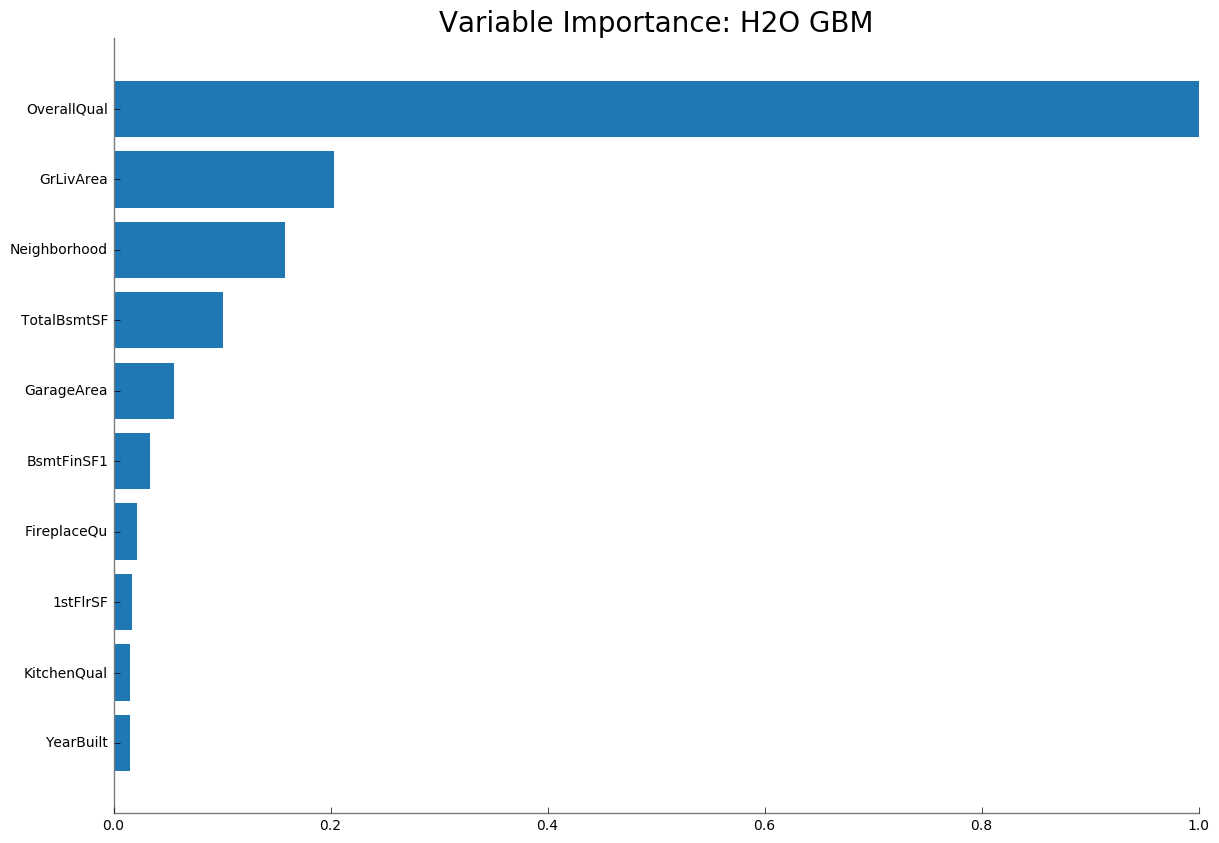

In [8]:
model.varimp_plot()

## One-dimensional partial dependence plots
* One-dimensional partial depedence plots (PDPs) show us the average behavior of a complex response function w.r.t a single input
* They allow us to compare this average behavior to domain knowledge and expected behavior
* The average behavior of PDPs can be misleading in the presence of strong interactions or for highly nonlinear response functions
* Great to explore most important variables in model

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |██

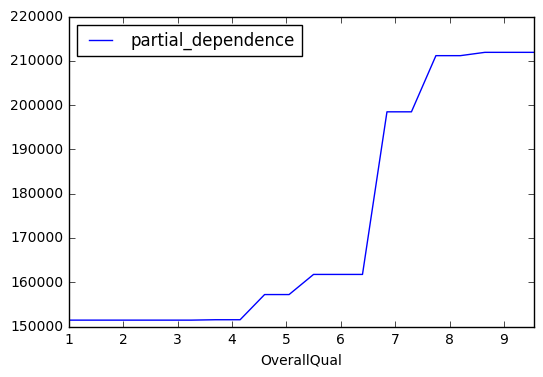

In [9]:
# manually calculate 1-D partial dependence
# for educational purposes

def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas dataframe containing partial dependence for a single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Data for which to calculate partial dependence.
        model: Model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which to calculate partial dependence.
    
    Returns:
        Pandas dataframe containing partial dependence values.
        
    """
    
    # init empty Pandas frame w/ correct col names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original data 
    col_cache = h2o.deep_copy(frame[xs], xid='col_cache')
  
    # determine values at which to calculate partial dependency
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependency  
    # by setting column of interest to constant 
    for j in bins:
        frame[xs] = j
        par_dep_i = model.predict(frame)
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame[xs] = h2o.get_frame('col_cache')

    return par_dep_frame

# show some output
par_dep_OverallQual = par_dep('OverallQual', valid, model)
par_dep_OverallQual.plot.line(x='OverallQual', y='partial_dependence')
print()
print(par_dep_OverallQual)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model GBM_model_python_1498482425595_1 on column 'OverallQual'



overallqual,mean_response,stddev_response
1.0,151437.6430347,37683.0437868
2.0,151437.6430347,37683.0437868
3.0,151437.6430347,37683.0437868
4.0,151526.2126269,37557.9397916
5.0,157213.1277631,37105.1150207
6.0,161758.6853642,38097.4935331
7.0,198475.4981422,52565.7395587
8.0,211158.0717007,53105.2466757
9.0,211906.4914021,54723.6048025
10.0,211906.4914021,54723.6048025


[]

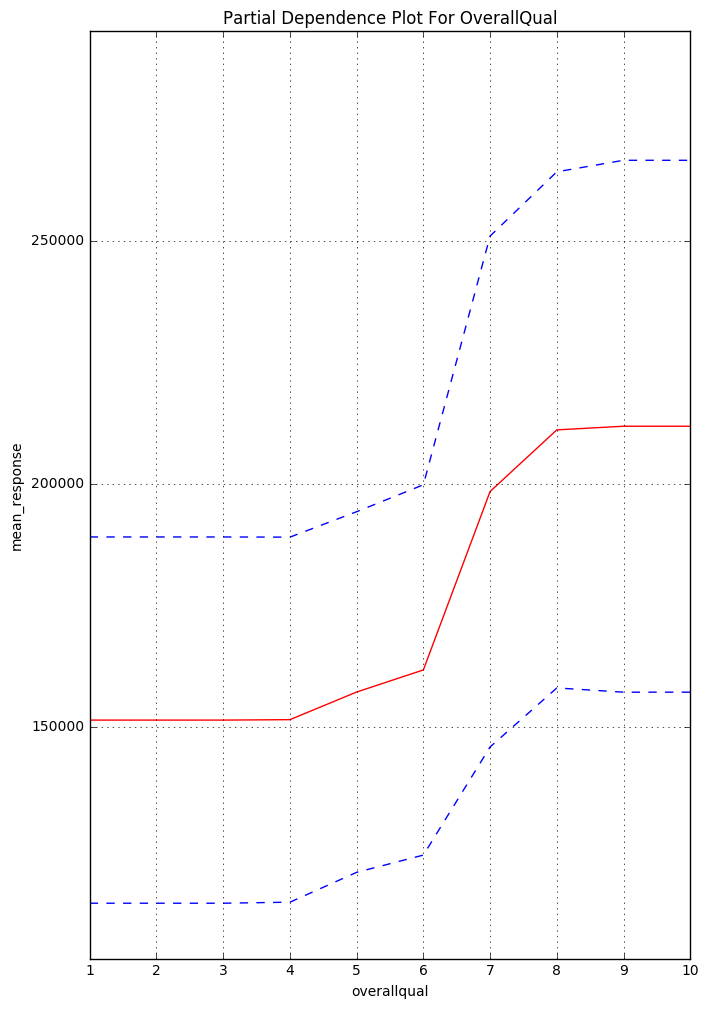

In [10]:
# use h2o to calculate 1-D partial dependence
# (easy, fast)
model.partial_plot(data=valid, cols=['OverallQual'], plot=True, plot_stddev=True)

## Two-dimensional partial dependence plots
* Most machine learning algorithms implicity model high degree interactions 
* Two-dimensional PDPs allow us see two-way interactions in a complex model 
* A significant drawback of PDPs is that they can only visualize 2nd degree interactions

#### Investigate one dimensional behavior

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


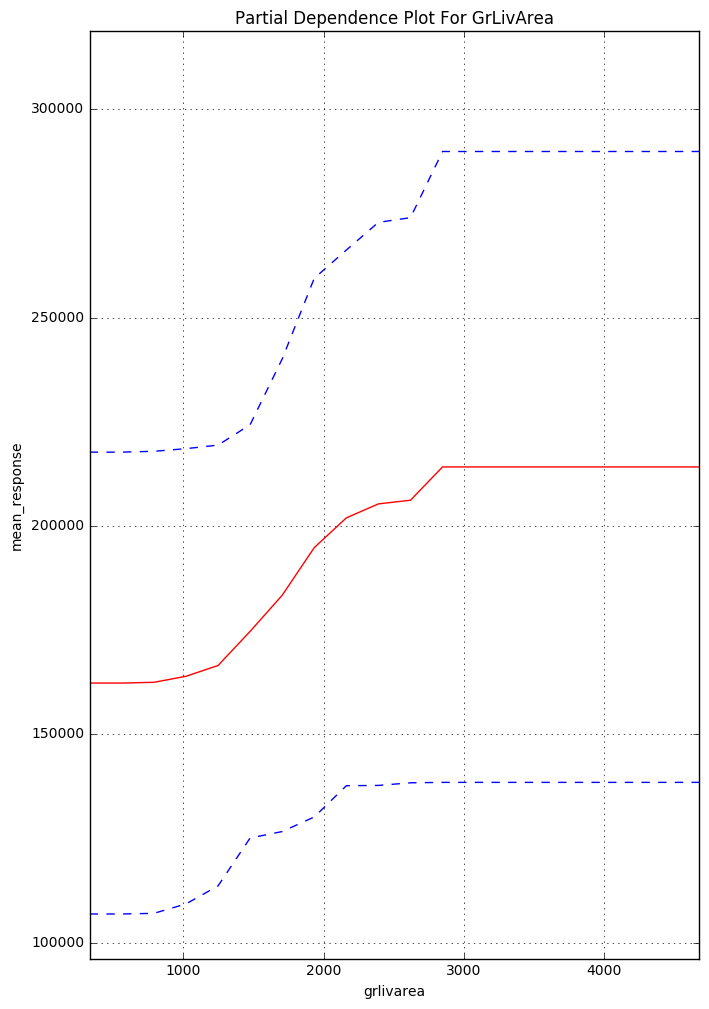

In [11]:
GrLivArea_housingMedianAge = model.partial_plot(data=valid, cols=['GrLivArea'], plot=True, plot_stddev=True)

#### Simple function for two-dimensional partial dependence 
* Using H2O for speed and scalability

In [12]:
# manually calculate 2-D partial dependence

def par_dep_2d(xs1, xs2, frame, model, resolution=20):
    
    """ Creates Pandas dataframe containing partial dependence for a two variables.
    
    Args:
        xs1: First variable for which to calculate partial dependence.
        xs2: Second variable for which to calculate partial dependence.
        frame: Data for which to calculate partial dependence.
        model: Model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which to calculate partial dependence.
    
    Returns:
        Pandas dataframe containing partial dependence values.
        
    """
    
    # init empty Pandas frame w/ correct col names
    par_dep_frame = pd.DataFrame(columns=[xs1, xs2, 'partial_dependence'])
    
    # cache original data 
    col_cache1 = frame[xs1]
    col_cache2 = frame[xs2] 
    
    # determine values at which to calculate partial dependency
    # for xs1
    min1_ = frame[xs1].min()
    max1_ = frame[xs1].max()
    by1 = float((max1_ - min1_)/resolution)
    range1 = np.arange(min1_, max1_, by1)
    
    # determine values at which to calculate partial dependency
    # for xs2
    min2_ = frame[xs2].min()
    max2_ = frame[xs2].max()
    by2 = float((max2_ - min2_)/resolution)
    range2 = np.arange(min2_, max2_, by2)  
    
    # calculate partial dependency 
    for j in range1:
        for k in range2:
            frame[xs1] = j
            frame[xs2] = k
            par_dep_i = model.predict(frame)
            par_dep_j = par_dep_i.mean()[0]
            std_j = model.predict(frame).sd()[0]
            pos_std, neg_std = par_dep_j + std_j, par_dep_j - std_j
            par_dep_frame = par_dep_frame.append({xs1:j,
                                                  xs2:k,
                                                  'partial_dependence': par_dep_j}, 
                                                  ignore_index=True)

    # return input frame to original cached state    
    frame[xs1] = col_cache1
    frame[xs2] = col_cache2

    return par_dep_frame

# calculate 2-D partial dependence
h2o.no_progress()
resolution = 20
par_dep_OverallQual_v_GrLivArea = par_dep_2d('OverallQual', 
                                             'GrLivArea', 
                                              valid, 
                                              model, 
                                              resolution=resolution)
print()
print(par_dep_OverallQual_v_GrLivArea)


     OverallQual  GrLivArea  partial_dependence
0           1.00      334.0       137143.703321
1           1.00      551.1       137143.703321
2           1.00      768.2       137322.618404
3           1.00      985.3       139150.945907
4           1.00     1202.4       142498.408185
5           1.00     1419.5       151866.473420
6           1.00     1636.6       154826.462650
7           1.00     1853.7       159341.580057
8           1.00     2070.8       166334.613333
9           1.00     2287.9       168582.463353
10          1.00     2505.0       169098.297178
11          1.00     2722.1       176320.530250
12          1.00     2939.2       176320.530250
13          1.00     3156.3       176320.530250
14          1.00     3373.4       176320.530250
15          1.00     3590.5       176320.530250
16          1.00     3807.6       176320.530250
17          1.00     4024.7       176320.530250
18          1.00     4241.8       176320.530250
19          1.00     4458.9       17632

#### Use matplotlib to plot two-dimensional partial dependence

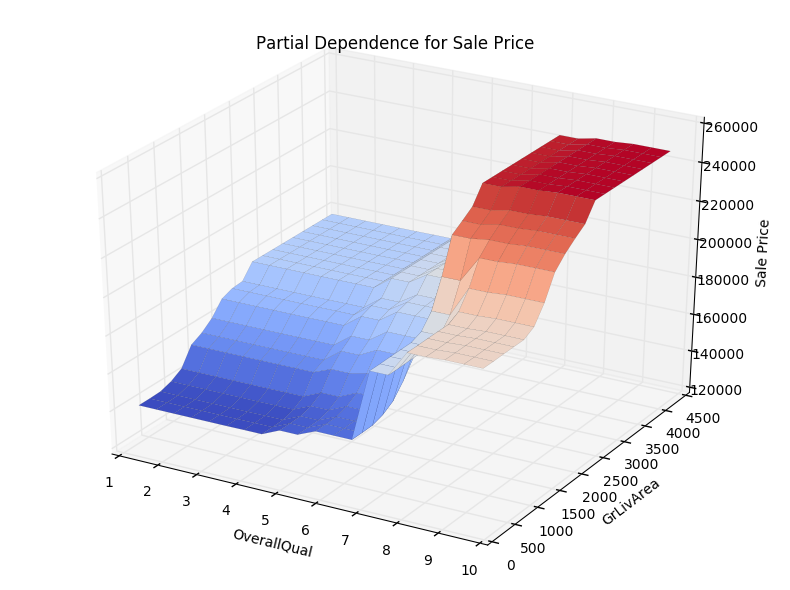

In [13]:
# create 2-D partial dependence plot

# imports
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# create 3-D grid 
new_shape = (resolution, resolution)
x = np.asarray(par_dep_OverallQual_v_GrLivArea['OverallQual']).reshape(new_shape)
y = np.asarray(par_dep_OverallQual_v_GrLivArea['GrLivArea']).reshape(new_shape)
z = np.asarray(par_dep_OverallQual_v_GrLivArea['partial_dependence']).reshape(new_shape)


fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

# set axes labels
ax.set_title('Partial Dependence for Sale Price')
ax.set_xlabel('OverallQual')
ax.set_ylabel('GrLivArea')
ax.set_zlabel('\nSale Price')

# axis decorators/details
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# surface
surf = ax.plot_surface(x, y, z, 
                       cmap=cm.coolwarm, 
                       linewidth=0.05, 
                       rstride=1, 
                       cstride=1, 
                       antialiased=True)
plt.tight_layout()

_ = plt.show()

## ICE Plots

#### Helper function for finding quantile indices

In [14]:
def get_quantile_dict(y, id_, frame):

    """ Returns the percentiles of a column y as the indices for another column id_.
    
    Args:
        y: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of y.
        frame: H2OFrame containing y and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    quantiles_df = frame.as_data_frame()
    quantiles_df.sort_values(y, inplace=True)
    quantiles_df.reset_index(inplace=True)
    
    percentiles_dict = {}
    percentiles_dict[0] = quantiles_df.loc[0, id_]
    percentiles_dict[99] = quantiles_df.loc[quantiles_df.shape[0]-1, id_]
    inc = quantiles_df.shape[0]//10
    
    for i in range(1, 10):
        percentiles_dict[i * 10] = quantiles_df.loc[i * inc,  id_]

    return percentiles_dict

quantile_dict = get_quantile_dict('SalePrice', 'Id', valid)

#### Find ICE values for each quantile

In [15]:
bins = list(par_dep_OverallQual['OverallQual'])
for i in sorted(quantile_dict.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_OverallQual[col_name] = par_dep('OverallQual', 
                                            valid[valid['Id'] == int(quantile_dict[i])], 
                                            model, 
                                            bins=bins)['partial_dependence']
par_dep_OverallQual

,OverallQual,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,1.00,151437.643035,75966.258632,94848.191445,123093.450807,129613.260252,127672.796017,162987.893141,177709.078304,178622.762375,186350.199401,194177.794341,244319.947630
1,1.45,151437.643035,75966.258632,94848.191445,123093.450807,129613.260252,127672.796017,162987.893141,177709.078304,178622.762375,186350.199401,194177.794341,244319.947630
2,1.90,151437.643035,75966.258632,94848.191445,123093.450807,129613.260252,127672.796017,162987.893141,177709.078304,178622.762375,186350.199401,194177.794341,244319.947630
3,2.35,151437.643035,75966.258632,94848.191445,123093.450807,129613.260252,127672.796017,162987.893141,177709.078304,178622.762375,186350.199401,194177.794341,244319.947630
4,2.80,151437.643035,75966.258632,94848.191445,123093.450807,129613.260252,127672.796017,162987.893141,177709.078304,178622.762375,186350.199401,194177.794341,244319.947630
5,3.25,151437.643035,75966.258632,94848.191445,123093.450807,129613.260252,127672.796017,162987.893141,177709.078304,178622.762375,186350.199401,194177.794341,244319.947630
6,3.70,151526.212627,75966.258632,94848.191445,123093.450807,129613.260252,127672.796017,162987.893141,177709.078304,178622.762375,186350.199401,194177.794341,244319.947630
7,4.15,151526.212627,75966.258632,94848.191445,123093.450807,129613.260252,127672.796017,162987.893141,177709.078304,178622.762375,186350.199401,194177.794341,244319.947630
8,4.60,157213.127763,77381.108050,94428.826455,123563.904725,133502.252095,139240.513318,167623.233904,179171.509762,190754.300217,198245.411620,194177.794341,256650.243223
9,5.05,157213.127763,77381.108050,94428.826455,123563.904725,133502.252095,139240.513318,167623.233904,179171.509762,190754.300217,198245.411620,194177.794341,256650.243223


#### Plot partial dependence and ICE for each quantile

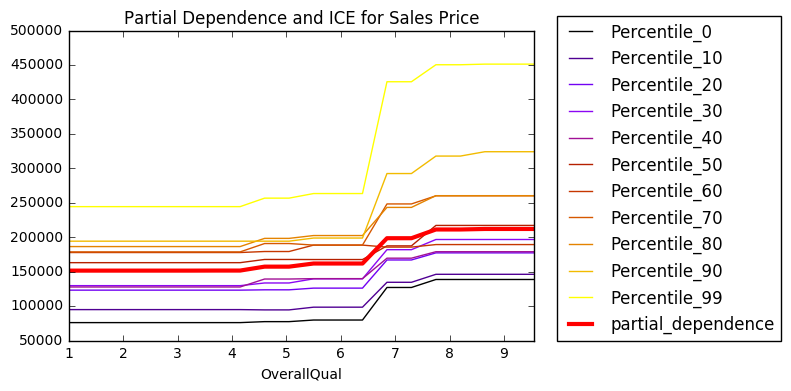

In [16]:
fig, ax = plt.subplots()
par_dep_OverallQual.drop('partial_dependence', axis=1).plot(x='OverallQual', colormap='gnuplot', ax=ax)

par_dep_OverallQual.plot(title='Partial Dependence and ICE for Sales Price',
                         x='OverallQual', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

From this partial dependence and ICE plot, it can be seen that most individual percentiles of predicted sale price are well-represented by partial dependence, except for the most expensive houses, above the 90th percentile. Pricing for these homes appears to behave differently than the average behavior of other homes under the model.

#### Shutdown H2O

In [17]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_bc16 closed.
